In [193]:
import pandas as pd
import random
import time
import numpy as np
import timeit
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [160]:
train_data = pd.read_csv("sales_train.csv")
items = pd.read_csv("items.csv")
test_data = pd.read_csv('test.csv')

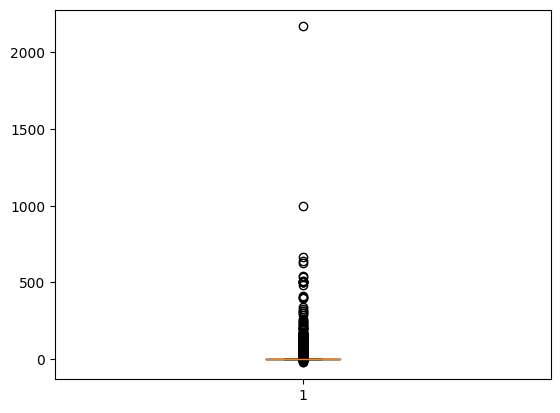

       date_block_num       shop_id       item_id    item_price  item_cnt_day
count    2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06
mean     1.456991e+01  3.300173e+01  1.019723e+04  8.908532e+02  1.242641e+00
std      9.422988e+00  1.622697e+01  6.324297e+03  1.729800e+03  2.618834e+00
min      0.000000e+00  0.000000e+00  0.000000e+00 -1.000000e+00 -2.200000e+01
25%      7.000000e+00  2.200000e+01  4.476000e+03  2.490000e+02  1.000000e+00
50%      1.400000e+01  3.100000e+01  9.343000e+03  3.990000e+02  1.000000e+00
75%      2.300000e+01  4.700000e+01  1.568400e+04  9.990000e+02  1.000000e+00
max      3.300000e+01  5.900000e+01  2.216900e+04  3.079800e+05  2.169000e+03


In [183]:
plt.boxplot(train_data["item_cnt_day"])
plt.show()
print(train_data.describe())

In [119]:
def rem_err_values(dataset):
    """
    Remove all values that are considered to be erroneous.
    """
    dataset = dataset[dataset["item_cnt_day"] > 0] #you cannot sell negative number of items
    return dataset

def find_outliers_iforrest(dataset):
    """Take one argument (pd.dataframe) and return this dataframe without the outliers.
    Removes column "date" in the process.
    """
    start = time.time()
    dataset = dataset.drop(columns="date")
    dataset = rem_err_values(dataset)
    iso = IsolationForest()
    outlier_model = iso.fit_predict(dataset)
    mask = outlier_model != -1
    dataset = dataset.loc[mask]
    print(f'Walltime: {time.time()-start}')
    return dataset
    
def find_outliers_IQR(dataset, column):
    dataset = dataset.drop(columns="date")
    Q1 = dataset[column].quantile(0.25)
    Q3 = dataset[column].quantile(0.75)
    IQR = Q3 - Q1
    dataset = dataset[dataset[column]<(Q3+1.5*IQR)]
    return dataset

df_test = find_outliers_iforrest(train_data)

(2935849, 5)
(2928493, 5)
Walltime: 53.183334827423096
(2442047, 5)


In [165]:
print(f'Missing values per group:\n{df_test.isna().sum()}\n')
def correlation(dataset):
    corr = dataset.corr()
    corr = corr[corr<1]
    corr = abs(corr)
    print(f'{corr}\n')
    corr = corr.loc[["item_cnt_day"]]
    print(f'Percentage correlation for item_cnt_day:\n{corr.max()*100}')
correlation(df_test)

Missing values per group:
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

                date_block_num   shop_id   item_id  item_price  item_cnt_day
date_block_num             NaN  0.019869  0.011397    0.109312      0.019591
shop_id               0.019869       NaN  0.039815    0.031233      0.017745
item_id               0.011397  0.039815       NaN    0.315148      0.000685
item_price            0.109312  0.031233  0.315148         NaN      0.039393
item_cnt_day          0.019591  0.017745  0.000685    0.039393           NaN

Percentage correlation for item_cnt_day
date_block_num    1.959061
shop_id           1.774532
item_id           0.068517
item_price        3.939251
item_cnt_day           NaN
dtype: float64


In [4]:
def linreg(dataset):
    X = dataset[["item_id"]]
    y = dataset[["item_cnt_day"]]
    reg = LinearRegression().fit(X, y)
    pred = reg.predict(X)
    rms = mean_squared_error(y, pred, squared=False)
    return rms
    
linreg(train_data)

2.618470946608825

In [3]:
items = items.drop(['item_name'], axis = 1)

In [190]:
df = pd.merge(items, train_data, how = 'inner')
df = df.drop(['date', 'item_price', 'item_name'], axis = 1)

,item_id,item_category_id,date_block_num,shop_id,item_cnt_day
0,0,40,20,54,1.0
1,1,76,15,55,1.0
2,1,76,15,55,1.0
3,1,76,18,55,1.0
4,1,76,19,55,1.0
...,...,...,...,...,...
2935844,22168,62,1,42,1.0
2935845,22168,62,1,16,1.0
2935846,22168,62,2,43,1.0
2935847,22168,62,8,12,1.0


In [192]:
temp_data = df.groupby(['date_block_num','shop_id','item_id','item_category_id']).sum().reset_index()
temp_data.rename(columns = {'item_cnt_day' : 'item_cnt_month'},inplace=True)
temp_data = temp_data.pivot_table(index=['shop_id','item_id', 'item_category_id'], columns='date_block_num', values='item_cnt_month').fillna(0.0)


         item_cnt_month
0                   6.0
1                   3.0
2                   1.0
3                   1.0
4                   2.0
...                 ...
1609119             6.0
1609120             2.0
1609121             1.0
1609122             1.0
1609123             1.0

[1609124 rows x 1 columns]


In [ ]:
X = temp_data.iloc[:,  (temp_data.columns != 33)].values
y = temp_data.iloc[:, temp_data.columns == 33].values
# x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3)
xgbtrain = xgb.DMatrix(X, y)
param = {'max_depth':10, 
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.3, 
         'num_round':1000, 
         'seed':1,
         'silent':0,
         'eval_metric':'rmse'}

bst = xgb.train(param, xgbtrain)
preds = bst.predict(xgb.DMatrix(temp_data.iloc[:,  (temp_data.columns != 33)].values))
rmse = np.sqrt(mean_squared_error(preds,temp_data.iloc[:, temp_data.columns == 33].values))
print(rmse)

In [ ]:
##################

In [201]:
temp_data = df.groupby(['date_block_num','shop_id','item_id','item_category_id']).sum().reset_index()
temp_data.rename(columns = {'item_cnt_day' : 'item_cnt_month'},inplace=True)
print(month)
print(temp_data)
temp_data = temp_data.pivot_table(index=['shop_id','item_id', 'item_category_id'], columns='date_block_num', values='item_cnt_month').fillna(0.0)

         item_cnt_month
0                   6.0
1                   3.0
2                   1.0
3                   1.0
4                   2.0
...                 ...
1609119             6.0
1609120             2.0
1609121             1.0
1609122             1.0
1609123             1.0

[1609124 rows x 1 columns]
         date_block_num  shop_id  item_id  item_category_id  item_cnt_month
0                     0        0       32                40             6.0
1                     0        0       33                37             3.0
2                     0        0       35                40             1.0
3                     0        0       43                40             1.0
4                     0        0       51                57             2.0
...                 ...      ...      ...               ...             ...
1609119              33       59    22087                83             6.0
1609120              33       59    22088                83             2.0


In [220]:
X = temp_data.iloc[:,  (temp_data.columns != 33)].values
y = temp_data.iloc[:, temp_data.columns == 33].values



xgbtrain = xgb.DMatrix(X, y)
# param = {'max_depth':10, 
#          'subsample':1,
#          'min_child_weight':0.5,
#          'eta':0.3, 
#          'num_round':1000, 
#          'seed':1,
#          'silent':0,
#          'eval_metric':'rmse'}

bst = xgb.XGBRegressor()
bst.fit(X,y)
preds = bst.predict(X)
rmse = np.sqrt(mean_squared_error(preds,y))
print(rmse)

0.11474680838669271


In [225]:
preds.max()

260.21536

In [187]:
submit_df = test_data.merge(temp_data, how = "left", on = ["shop_id", "item_id"]).fillna(0.0)
submit_df.iloc[:,(submit_df.columns != 'ID')]
print(submit_df.iloc[:,3:].shape)
# preds = bst.predict(submit_df.iloc[:,(submit_df.columns != 'ID')].values)

(214200, 34)
